In [1]:
%matplotlib inline

from urllib.request import urlretrieve
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import Dataset
DATA_HOST = 'https://data.open-power-system-data.org/time_series/2019-06-05'
ARCHIVE_NAME = 'time_series_60min_singleindex.csv'
FILE_NAME = ARCHIVE_NAME[:-4]

if not os.path.isfile(ARCHIVE_NAME):
    print("Downloading dataset...")
    urlretrieve(DATA_HOST + '/' + ARCHIVE_NAME, ARCHIVE_NAME)
    
else:
    print("File found. Skipping download")

File found. Skipping download


In [3]:
# Columns of interest
filter_col = ['cet_cest_timestamp','DE_price_day_ahead','DE_load_actual_entsoe_transparency','DE_solar_generation_actual','DE_wind_generation_actual']

In [4]:
data_filtered_df=pd.read_csv("time_series_60min_singleindex.csv", usecols=filter_col)

In [5]:
list(data_filtered_df.columns)

['cet_cest_timestamp',
 'DE_load_actual_entsoe_transparency',
 'DE_price_day_ahead',
 'DE_solar_generation_actual',
 'DE_wind_generation_actual']

In [6]:
data_filtered_df.shape

(125593, 5)

In [7]:
# Preprocessing the timesatmp column to get Year, Month , Day and Hour in single columns
time1=data_filtered_df['cet_cest_timestamp'].str.split("-",expand=True)
time2=time1.iloc[:,2].str.split("T",expand=True)
time3=time2.iloc[:,1].str.split("+",expand=True)

In [8]:
time_df=pd.concat([time1.iloc[:,0:2],time2.iloc[:,0],time3.iloc[:,0]] ,axis=1)
time_df.columns=['Year','Month','Day','Hour']

In [9]:
time_df.head()

,Year,Month,Day,Hour
0,2005,01,01,00:00:00
1,2005,01,01,01:00:00
2,2005,01,01,02:00:00
3,2005,01,01,03:00:00
4,2005,01,01,04:00:00


In [10]:
data_filtered_df = pd.concat([time_df,data_filtered_df], axis=1)
data_filtered_df.head()

,Year,Month,Day,Hour,cet_cest_timestamp,DE_load_actual_entsoe_transparency,DE_price_day_ahead,DE_solar_generation_actual,DE_wind_generation_actual
0,2005,01,01,00:00:00,2005-01-01T00:00:00+0100,NaN,NaN,NaN,NaN
1,2005,01,01,01:00:00,2005-01-01T01:00:00+0100,NaN,20.05,NaN,NaN
2,2005,01,01,02:00:00,2005-01-01T02:00:00+0100,NaN,15.00,NaN,NaN
3,2005,01,01,03:00:00,2005-01-01T03:00:00+0100,NaN,13.41,NaN,NaN
4,2005,01,01,04:00:00,2005-01-01T04:00:00+0100,NaN,13.73,NaN,NaN


In [11]:
# Chequing how many NaN values there are in the first 7 days of January 2019
pd.set_option('display.max_rows', 750)
data_filtered_df[data_filtered_df['Year']=='2019'][data_filtered_df['Month']=='01'][data_filtered_df['Day']<='07'][filter_col[4]]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


122712    23132.0
122713    24904.0
122714    25208.0
122715    26568.0
122716    28500.0
122717    29808.0
122718    31016.0
122719    31950.0
122720    32648.0
122721    32274.0
122722    33466.0
122723    35712.0
122724    35900.0
122725    36454.0
122726    36867.0
122727    36849.0
122728    37955.0
122729    38550.0
122730    38530.0
122731    38218.0
122732    38198.0
122733    37767.0
122734    36827.0
122735    36464.0
122736    34601.0
122737    33649.0
122738    33107.0
122739    32585.0
122740    32960.0
122741    34039.0
122742    35156.0
122743    35332.0
122744    34088.0
122745    32990.0
122746    32370.0
122747    32195.0
122748    32118.0
122749    31469.0
122750    29458.0
122751    27170.0
122752    25558.0
122753    24494.0
122754    22652.0
122755    20892.0
122756    19242.0
122757    17852.0
122758    16656.0
122759    15415.0
122760    15164.0
122761    15214.0
122762    14763.0
122763    15220.0
122764    15923.0
122765    16592.0
122766    16814.0
122767    

In [12]:
# Extracting the time series of interest
column_df=data_filtered_df.copy()

In [13]:
# Indexing by Datetime
column_df['Datetime'] = pd.to_datetime(column_df['Year']+'-'+column_df['Month']+'-'+column_df['Day']+' '+column_df['Hour'])
column_df = column_df.set_index('Datetime')
column_s1=column_df[filter_col[1]].copy()
column_s2=column_df[filter_col[2]].copy()
column_s3=column_df[filter_col[3]].copy()
column_s4=column_df[filter_col[4]].copy()

In [14]:
# Function to split the whole multiyear time series in several 1-year slices
def make_time_series(mean_power_df, years):
    '''Creates as many time series as there are complete years.
    
      :param mean_power_df: A Pandas Series with time varying data. This dataframe should also be indexed by a datetime.
      :param years: A list of years (string format) to make time series out of, ex. ['2007', '2008'].
      
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
        
    # create time series for each year in years
    for i in range(len(years)):

        year = years[i]

        data=mean_power_df.loc[year+'-01-01 00:00:00':year+'-12-31 23:00:00']

        # create time series for the year
        time_series.append(pd.Series(data=data))
    
    # return list of time series
    return time_series
    

In [15]:
# test out the code above
# yearly time series for the complete years of interest
full_years = ['2015','2016','2017','2018']

# make time series
time_series_1 = make_time_series(column_s1, full_years)
time_series_2 = make_time_series(column_s2, full_years)
time_series_3 = make_time_series(column_s3, full_years)
time_series_4 = make_time_series(column_s4, full_years)

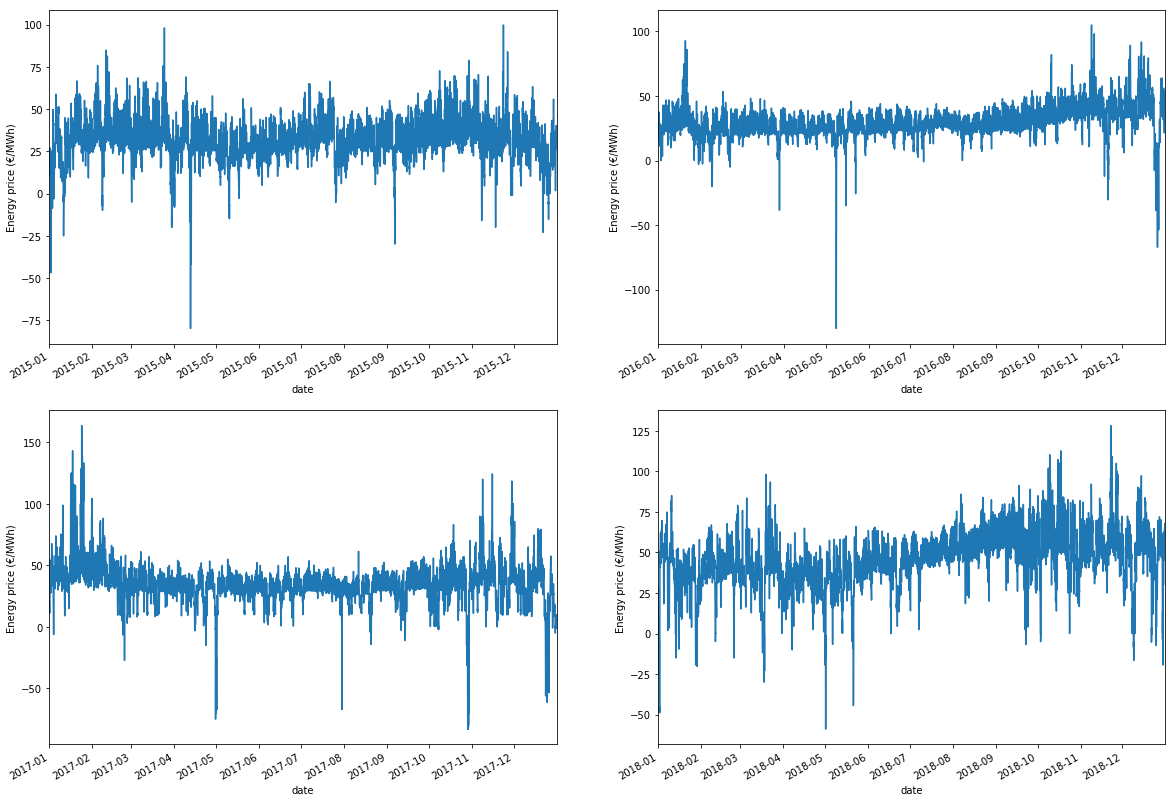

In [16]:
# display time series: Energy price
fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharex=False)
axx = axs.ravel()
for i in range(len(full_years)):
    time_series_1[i].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("Energy price (€/MWh)")   
    axx[i].grid(which='minor', axis='x')


In [17]:
# Price statistics
print('Year' + '   ' + 'mean' + '   ' + 'std')
print('----' + '   ' + '----' + '   ' + '----')
for i in range(len(full_years)):
    print(full_years[i] + '   ' + str(round(time_series_1[i].mean(),1)) + '   ' + str(round(time_series_1[i].std(),1)))

Year   mean   std
----   ----   ----
2015   31.6   12.7
2016   29.0   12.5
2017   34.2   17.6
2018   44.9   17.6


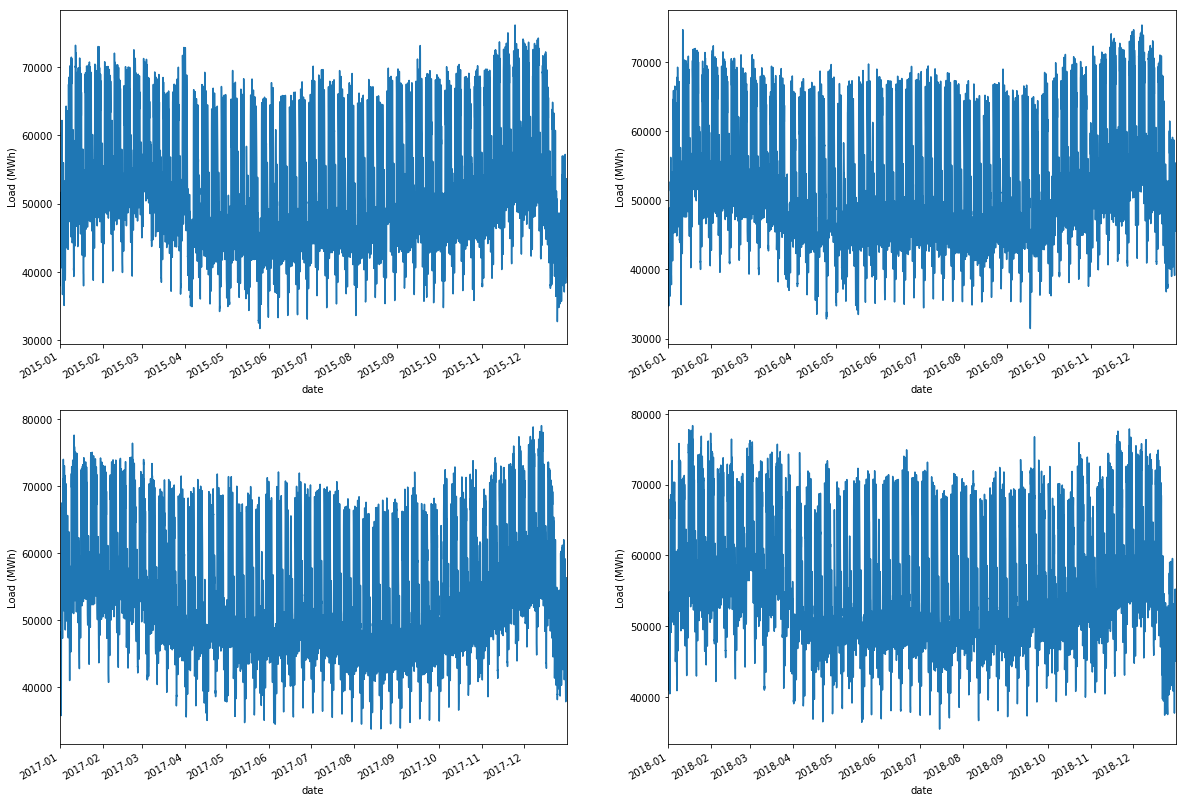

In [18]:
# display time series: Load
fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharex=False)
axx = axs.ravel()
for i in range(len(full_years)):
    time_series_2[i].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("Load (MWh)")   
    axx[i].grid(which='minor', axis='x')

In [19]:
# Load statistics
print('Year' + '   ' + 'mean' + '   ' + 'std')
print('----' + '   ' + '----' + '   ' + '----')
for i in range(len(full_years)):
    print(full_years[i] + '   ' + str(round(time_series_2[i].mean(),1)) + '   ' + str(round(time_series_2[i].std(),1)))

Year   mean   std
----   ----   ----
2015   54557.5   9983.4
2016   54768.3   9788.4
2017   56309.5   10263.1
2018   58060.8   9894.0


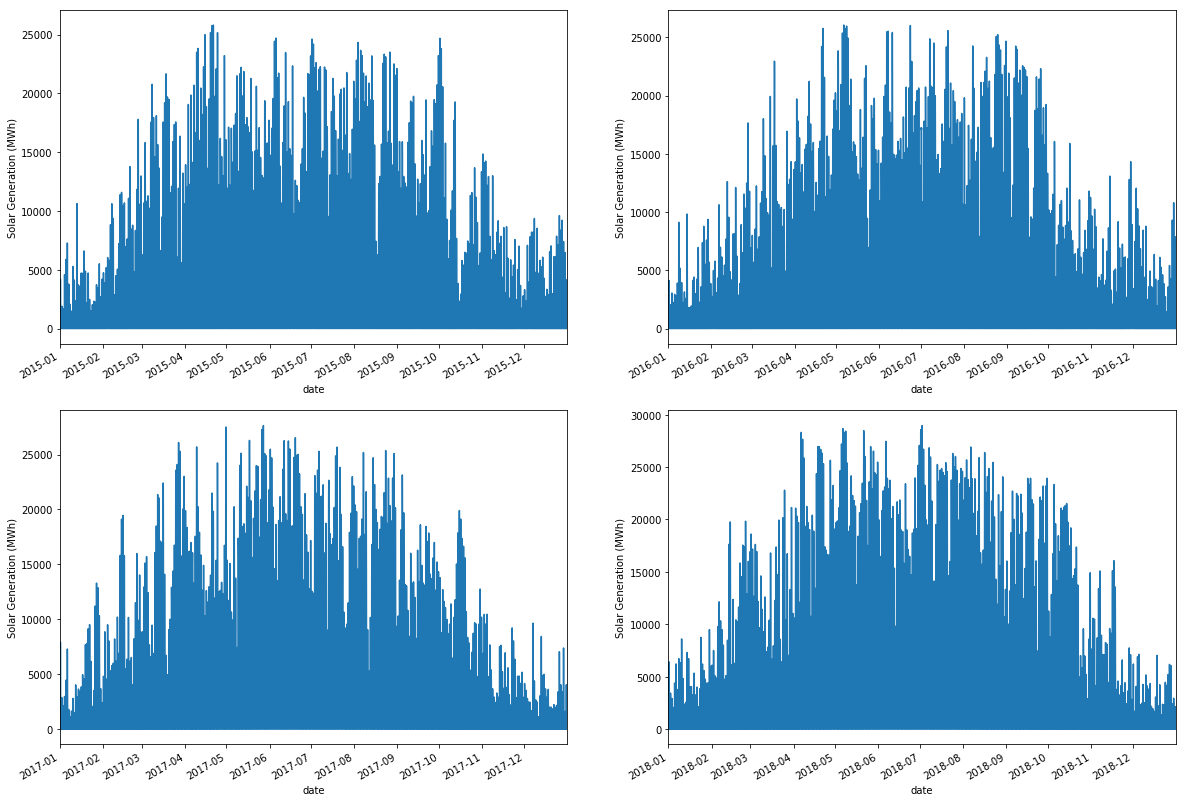

In [20]:
# display time series: Solar Generation
fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharex=False)
axx = axs.ravel()
for i in range(len(full_years)):
    time_series_3[i].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("Solar Generation (MWh)")   
    axx[i].grid(which='minor', axis='x')

In [21]:
# Solar statistics
print('Year' + '   ' + 'mean' + '   ' + 'std')
print('----' + '   ' + '----' + '   ' + '----')
for i in range(len(full_years)):
    print(full_years[i] + '   ' + str(round(time_series_3[i].mean(),1)) + '   ' + str(round(time_series_3[i].std(),1)))

Year   mean   std
----   ----   ----
2015   3984.8   6043.2
2016   3934.7   6032.5
2017   4096.2   6314.3
2018   4707.1   7165.3


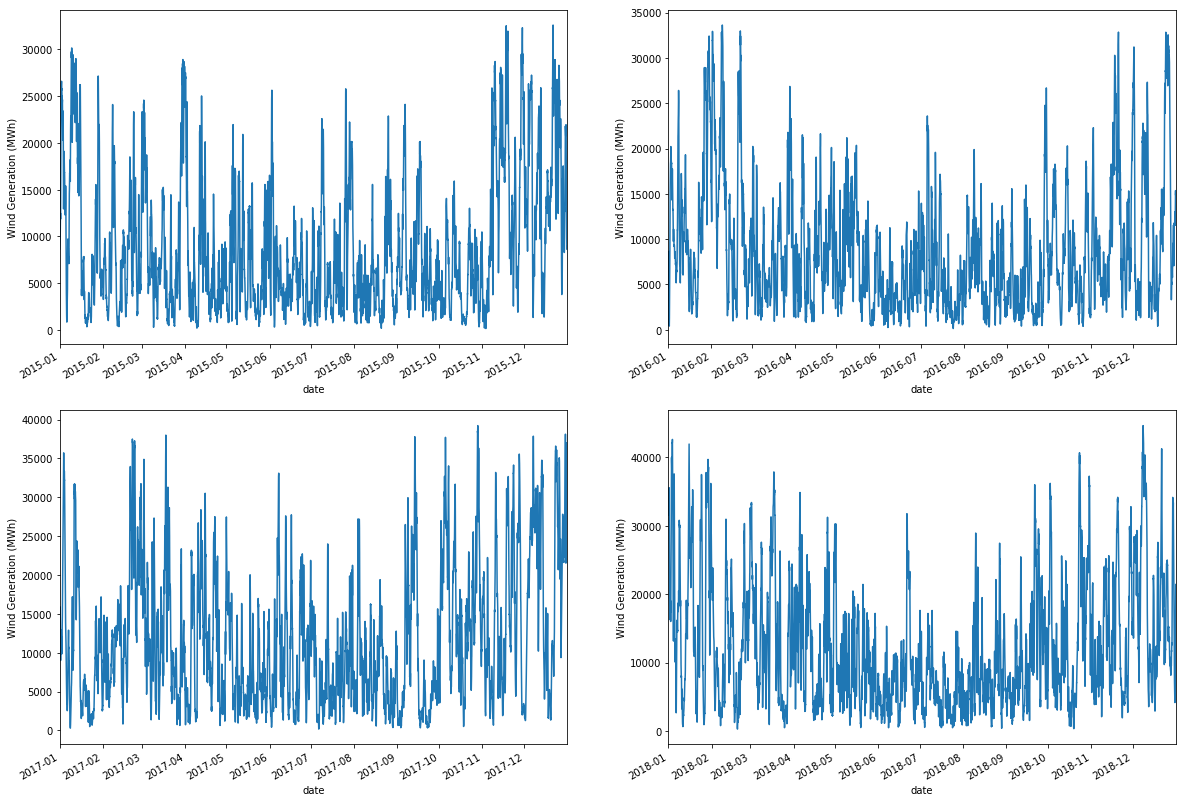

In [22]:
# display time series: Wind Generation
fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharex=False)
axx = axs.ravel()
for i in range(len(full_years)):
    time_series_4[i].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("Wind Generation (MWh)")   
    axx[i].grid(which='minor', axis='x')

In [23]:
# Wind statistics
print('Year' + '   ' + 'mean' + '   ' + 'std')
print('----' + '   ' + '----' + '   ' + '----')
for i in range(len(full_years)):
    print(full_years[i] + '   ' + str(round(time_series_4[i].mean(),1)) + '   ' + str(round(time_series_4[i].std(),1)))

Year   mean   std
----   ----   ----
2015   8843.5   7158.1
2016   8766.1   6846.0
2017   11718.2   8811.0
2018   12394.5   9048.4


### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, in forecasting it is important to do this train/test split based on time rather than by time series.

In this example, we will reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

In [24]:
# we use 1 hour frequency for the time series
freq = 'H'

# we predict for 7 days
prediction_length = 7 * 24

# we also use 7 days as context length
context_length = prediction_length

# to use a part of the time series to test
testing = True
        
# Replace NaN with "NaN" in the target time series so that DeepAR can handle with them and with mean value in dynamic feature time series
x="NaN"
for i in range(len(full_years)):
    time_series_1[i]=time_series_1[i].fillna(x)
    time_series_2[i]=time_series_2[i].fillna(time_series_2[i].mean())
    time_series_3[i]=time_series_3[i].fillna(time_series_3[i].mean())
    time_series_4[i]=time_series_4[i].fillna(time_series_4[i].mean())

The DeepAR JSON input format represents each time series as a JSON object (dictionary). In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which we will use later.

In [25]:
if testing == True:
    training_data = [
        {
            "start": str(ts.index[0]),
            "target": ts[:-prediction_length].tolist(),
            "dynamic_feat": [time_series_2[i][:-prediction_length].tolist(),time_series_3[i][:-prediction_length].tolist(),time_series_4[i][:-prediction_length].tolist()]
        }
        for i, ts in enumerate(time_series_1)
    ]

As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 7 days, and comparing predictions with actual values.
To evaluate our model performance on more than one week, we generate test data that extends to 1, 2, 3, 4 weeks beyond the training range. This way we perform *rolling evaluation* of our model.

In [26]:
test_data = [
    {
        "start": str(ts.index[0]),
        "target": ts.tolist(),
        "dynamic_feat": [time_series_2[i].tolist(),time_series_3[i].tolist(),time_series_4[i].tolist()]
    }
    for i,ts in enumerate(time_series_1)
]

if testing == False:
    training_data = test_data

### Saving Data, Locally

The next helper function will write each time series to a single JSON line, using the new line character '\n'. The data is also encoded and written to a filename that we specify.

In [27]:
import json

def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [28]:
# save this data to a local directory. If it does not exist create it
data_dir = 'json_energy_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# directories to save train/test data
train_key = os.path.join(data_dir, 'train_dynamic.json')
test_key = os.path.join(data_dir, 'test_dynamic.json')

In [29]:
%%time
write_dicts_to_file(train_key, training_data)
write_dicts_to_file(test_key, test_data)

CPU times: user 65.8 ms, sys: 8.08 ms, total: 73.8 ms
Wall time: 73.6 ms


---
## Uploading Data to S3

Next, to make this data accessible to an estimator, I'll upload it to S3.

### Sagemaker resources

Let's start by specifying:
* The sagemaker role and session for training a model.
* A default S3 bucket where we can save our training, test, and model data.

In [30]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [31]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()

### EXERCISE: Upoad *both* training and test JSON files to S3

Specify *unique* train and test prefixes that define the location of that data in S3.
* Upload training data to a location in S3, and save that location to `train_path`
* Upload test data to a location in S3, and save that location to `test_path`

In [32]:
# general prefix
prefix='deepar-capstone_price'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [33]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-1-720055693808/deepar-capstone_price/train/train_dynamic.json
Test data is stored in: s3://sagemaker-us-east-1-720055693808/deepar-capstone_price/test/test_dynamic.json


---
# Training a DeepAR Estimator

Here we define the estimator that will launch the trainig job.

Next, we configure the container image to be used for the region that we are running in.

In [34]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name,'forecasting-deepar')

In [35]:
# Instantiate an estimator
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.4xlarge',
                      output_path=s3_output_path
                      )

## Setting Hyperparameters
Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case.

In [36]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "100",
    "early_stopping_patience": "10",
    "mini_batch_size": "256",
    "learning_rate": "0.001",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_dynamic_feat": "auto", #"ignore"
    "num_layers": "4",
    "num_cells": "75"
}

estimator.set_hyperparameters(**hyperparameters)

## Training Job
We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model (model artifacts).

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series.  The computed error metrics will be included as part of the log output.

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [37]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-01-11 17:04:25 Starting - Starting the training job...
2020-01-11 17:04:27 Starting - Launching requested ML instances.........
2020-01-11 17:05:59 Starting - Preparing the instances for training...
2020-01-11 17:06:40 Downloading - Downloading input data...
2020-01-11 17:07:26 Training - Training image download completed. Training in progress..Arguments: train
[01/11/2020 17:07:28 INFO 140718492968768] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience':

[01/11/2020 17:09:00 INFO 140718492968768] Epoch[2] Batch[5] avg_epoch_loss=3.762166
[01/11/2020 17:09:00 INFO 140718492968768] #quality_metric: host=algo-1, epoch=2, batch=5 train loss <loss>=3.76216562589
[01/11/2020 17:09:00 INFO 140718492968768] Epoch[2] Batch [5]#011Speed: 85.26 samples/sec#011loss=3.762166
[01/11/2020 17:09:12 INFO 140718492968768] processed a total of 2531 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 30978.76501083374, "sum": 30978.76501083374, "min": 30978.76501083374}}, "EndTime": 1578762552.538303, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578762521.559474}

[01/11/2020 17:09:12 INFO 140718492968768] #throughput_metric: host=algo-1, train throughput=81.7008020803 records/second
[01/11/2020 17:09:12 INFO 140718492968768] #progress_metric: host=algo-1, completed 3 % of epochs
[01/11/2020 17:09:12 INFO 140718492968768] #quality_metric: host=algo-1, epoch=2, train loss <loss>=3.7496271

[01/11/2020 17:11:42 INFO 140718492968768] Epoch[7] Batch[5] avg_epoch_loss=3.550177
[01/11/2020 17:11:42 INFO 140718492968768] #quality_metric: host=algo-1, epoch=7, batch=5 train loss <loss>=3.55017721653
[01/11/2020 17:11:42 INFO 140718492968768] Epoch[7] Batch [5]#011Speed: 84.97 samples/sec#011loss=3.550177
[01/11/2020 17:11:54 INFO 140718492968768] processed a total of 2529 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 31031.805992126465, "sum": 31031.805992126465, "min": 31031.805992126465}}, "EndTime": 1578762714.567411, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578762683.535167}

[01/11/2020 17:11:54 INFO 140718492968768] #throughput_metric: host=algo-1, train throughput=81.4967086451 records/second
[01/11/2020 17:11:54 INFO 140718492968768] #progress_metric: host=algo-1, completed 8 % of epochs
[01/11/2020 17:11:54 INFO 140718492968768] #quality_metric: host=algo-1, epoch=7, train loss <loss>=3.5426

[01/11/2020 17:14:21 INFO 140718492968768] Epoch[12] Batch[5] avg_epoch_loss=3.428863
[01/11/2020 17:14:21 INFO 140718492968768] #quality_metric: host=algo-1, epoch=12, batch=5 train loss <loss>=3.42886312803
[01/11/2020 17:14:21 INFO 140718492968768] Epoch[12] Batch [5]#011Speed: 85.08 samples/sec#011loss=3.428863
[01/11/2020 17:14:33 INFO 140718492968768] processed a total of 2505 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 31052.929162979126, "sum": 31052.929162979126, "min": 31052.929162979126}}, "EndTime": 1578762873.474296, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578762842.421309}

[01/11/2020 17:14:33 INFO 140718492968768] #throughput_metric: host=algo-1, train throughput=80.6684069232 records/second
[01/11/2020 17:14:33 INFO 140718492968768] #progress_metric: host=algo-1, completed 13 % of epochs
[01/11/2020 17:14:33 INFO 140718492968768] #quality_metric: host=algo-1, epoch=12, train loss <loss>=3

[01/11/2020 17:17:00 INFO 140718492968768] Epoch[17] Batch[5] avg_epoch_loss=3.416679
[01/11/2020 17:17:00 INFO 140718492968768] #quality_metric: host=algo-1, epoch=17, batch=5 train loss <loss>=3.41667886575
[01/11/2020 17:17:00 INFO 140718492968768] Epoch[17] Batch [5]#011Speed: 85.13 samples/sec#011loss=3.416679
[01/11/2020 17:17:15 INFO 140718492968768] Epoch[17] Batch[10] avg_epoch_loss=3.432422
[01/11/2020 17:17:15 INFO 140718492968768] #quality_metric: host=algo-1, epoch=17, batch=10 train loss <loss>=3.45131421089
[01/11/2020 17:17:15 INFO 140718492968768] Epoch[17] Batch [10]#011Speed: 84.78 samples/sec#011loss=3.451314
[01/11/2020 17:17:15 INFO 140718492968768] processed a total of 2602 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 34050.14896392822, "sum": 34050.14896392822, "min": 34050.14896392822}}, "EndTime": 1578763035.603147, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578763001.552482}

[01/11

[01/11/2020 17:19:42 INFO 140718492968768] Epoch[22] Batch[5] avg_epoch_loss=3.375711
[01/11/2020 17:19:42 INFO 140718492968768] #quality_metric: host=algo-1, epoch=22, batch=5 train loss <loss>=3.37571056684
[01/11/2020 17:19:42 INFO 140718492968768] Epoch[22] Batch [5]#011Speed: 84.66 samples/sec#011loss=3.375711
[01/11/2020 17:19:57 INFO 140718492968768] Epoch[22] Batch[10] avg_epoch_loss=3.423048
[01/11/2020 17:19:57 INFO 140718492968768] #quality_metric: host=algo-1, epoch=22, batch=10 train loss <loss>=3.47985215187
[01/11/2020 17:19:57 INFO 140718492968768] Epoch[22] Batch [10]#011Speed: 84.42 samples/sec#011loss=3.479852
[01/11/2020 17:19:57 INFO 140718492968768] processed a total of 2572 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 34198.92692565918, "sum": 34198.92692565918, "min": 34198.92692565918}}, "EndTime": 1578763197.723714, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578763163.524717}

[01/11

[01/11/2020 17:22:30 INFO 140718492968768] Epoch[27] Batch[5] avg_epoch_loss=3.323183
[01/11/2020 17:22:30 INFO 140718492968768] #quality_metric: host=algo-1, epoch=27, batch=5 train loss <loss>=3.32318309943
[01/11/2020 17:22:30 INFO 140718492968768] Epoch[27] Batch [5]#011Speed: 84.92 samples/sec#011loss=3.323183
[01/11/2020 17:22:45 INFO 140718492968768] Epoch[27] Batch[10] avg_epoch_loss=3.339369
[01/11/2020 17:22:45 INFO 140718492968768] #quality_metric: host=algo-1, epoch=27, batch=10 train loss <loss>=3.35879125595
[01/11/2020 17:22:45 INFO 140718492968768] Epoch[27] Batch [10]#011Speed: 84.48 samples/sec#011loss=3.358791
[01/11/2020 17:22:45 INFO 140718492968768] processed a total of 2577 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 34164.92795944214, "sum": 34164.92795944214, "min": 34164.92795944214}}, "EndTime": 1578763365.64625, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578763331.480866}

[01/11/

[01/11/2020 17:25:15 INFO 140718492968768] Epoch[32] Batch[5] avg_epoch_loss=3.308774
[01/11/2020 17:25:15 INFO 140718492968768] #quality_metric: host=algo-1, epoch=32, batch=5 train loss <loss>=3.30877375603
[01/11/2020 17:25:15 INFO 140718492968768] Epoch[32] Batch [5]#011Speed: 84.99 samples/sec#011loss=3.308774
[01/11/2020 17:25:27 INFO 140718492968768] processed a total of 2472 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 31083.484888076782, "sum": 31083.484888076782, "min": 31083.484888076782}}, "EndTime": 1578763527.620143, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578763496.536199}

[01/11/2020 17:25:27 INFO 140718492968768] #throughput_metric: host=algo-1, train throughput=79.5274500578 records/second
[01/11/2020 17:25:27 INFO 140718492968768] #progress_metric: host=algo-1, completed 33 % of epochs
[01/11/2020 17:25:27 INFO 140718492968768] #quality_metric: host=algo-1, epoch=32, train loss <loss>=3

[01/11/2020 17:28:00 INFO 140718492968768] Epoch[37] Batch[5] avg_epoch_loss=3.335716
[01/11/2020 17:28:00 INFO 140718492968768] #quality_metric: host=algo-1, epoch=37, batch=5 train loss <loss>=3.33571557204
[01/11/2020 17:28:00 INFO 140718492968768] Epoch[37] Batch [5]#011Speed: 85.01 samples/sec#011loss=3.335716
[01/11/2020 17:28:12 INFO 140718492968768] processed a total of 2524 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 31113.94691467285, "sum": 31113.94691467285, "min": 31113.94691467285}}, "EndTime": 1578763692.475525, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578763661.361139}

[01/11/2020 17:28:12 INFO 140718492968768] #throughput_metric: host=algo-1, train throughput=81.1208010927 records/second
[01/11/2020 17:28:12 INFO 140718492968768] #progress_metric: host=algo-1, completed 38 % of epochs
[01/11/2020 17:28:12 INFO 140718492968768] #quality_metric: host=algo-1, epoch=37, train loss <loss>=3.33

[01/11/2020 17:30:54 INFO 140718492968768] Epoch[42] Batch[10] avg_epoch_loss=3.263316
[01/11/2020 17:30:54 INFO 140718492968768] #quality_metric: host=algo-1, epoch=42, batch=10 train loss <loss>=3.25003991127
[01/11/2020 17:30:54 INFO 140718492968768] Epoch[42] Batch [10]#011Speed: 84.63 samples/sec#011loss=3.250040
[01/11/2020 17:30:54 INFO 140718492968768] processed a total of 2576 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 34143.72181892395, "sum": 34143.72181892395, "min": 34143.72181892395}}, "EndTime": 1578763854.240737, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578763820.096959}

[01/11/2020 17:30:54 INFO 140718492968768] #throughput_metric: host=algo-1, train throughput=75.4455288663 records/second
[01/11/2020 17:30:54 INFO 140718492968768] #progress_metric: host=algo-1, completed 43 % of epochs
[01/11/2020 17:30:54 INFO 140718492968768] #quality_metric: host=algo-1, epoch=42, train loss <loss>=3

[01/11/2020 17:33:55 INFO 140718492968768] Epoch[48] Batch[5] avg_epoch_loss=3.347679
[01/11/2020 17:33:55 INFO 140718492968768] #quality_metric: host=algo-1, epoch=48, batch=5 train loss <loss>=3.34767913818
[01/11/2020 17:33:55 INFO 140718492968768] Epoch[48] Batch [5]#011Speed: 84.74 samples/sec#011loss=3.347679
[01/11/2020 17:34:10 INFO 140718492968768] Epoch[48] Batch[10] avg_epoch_loss=3.347373
[01/11/2020 17:34:10 INFO 140718492968768] #quality_metric: host=algo-1, epoch=48, batch=10 train loss <loss>=3.34700651169
[01/11/2020 17:34:10 INFO 140718492968768] Epoch[48] Batch [10]#011Speed: 84.50 samples/sec#011loss=3.347007
[01/11/2020 17:34:10 INFO 140718492968768] processed a total of 2568 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 34203.16290855408, "sum": 34203.16290855408, "min": 34203.16290855408}}, "EndTime": 1578764050.213167, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578764016.00994}

[01/11/

[01/11/2020 17:36:55 INFO 140718492968768] Epoch[53] Batch[10] avg_epoch_loss=3.280876
[01/11/2020 17:36:55 INFO 140718492968768] #quality_metric: host=algo-1, epoch=53, batch=10 train loss <loss>=3.24647488594
[01/11/2020 17:36:55 INFO 140718492968768] Epoch[53] Batch [10]#011Speed: 85.00 samples/sec#011loss=3.246475
[01/11/2020 17:36:55 INFO 140718492968768] processed a total of 2566 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 34023.029088974, "sum": 34023.029088974, "min": 34023.029088974}}, "EndTime": 1578764215.008048, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578764180.984709}

[01/11/2020 17:36:55 INFO 140718492968768] #throughput_metric: host=algo-1, train throughput=75.4192520073 records/second
[01/11/2020 17:36:55 INFO 140718492968768] #progress_metric: host=algo-1, completed 54 % of epochs
[01/11/2020 17:36:55 INFO 140718492968768] #quality_metric: host=algo-1, epoch=53, train loss <loss>=3.28087

#metrics {"Metrics": {"get_graph.time": {"count": 1, "max": 5016.152858734131, "sum": 5016.152858734131, "min": 5016.152858734131}}, "EndTime": 1578764347.226101, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578764342.209185}

[01/11/2020 17:39:08 INFO 140718492968768] Number of GPUs being used: 0
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 5827.885866165161, "sum": 5827.885866165161, "min": 5827.885866165161}}, "EndTime": 1578764348.037788, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578764347.226201}

[01/11/2020 17:39:08 INFO 140718492968768] Serializing to /opt/ml/model/model_algo-1
[01/11/2020 17:39:08 INFO 140718492968768] Saved checkpoint to "/opt/ml/model/model_algo-1-0000.params"
#metrics {"Metrics": {"model.serialize.time": {"count": 1, "max": 129.75192070007324, "sum": 129.75192070007324, "min": 129.75192070007324}}, "EndTime": 1578764348.167638, "Dim

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

Remember to **delete the endpoint** at the end of this notebook. A cell at the very bottom of this notebook will be provided, but it is always good to keep, front-of-mind.

In [38]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    content_type="application/json" # specify that it will accept/produce JSON
)
print("Pedictor attached to Endpoint: {}".format(predictor.endpoint))

----------------------------------------------------------------------------------------------------!CPU times: user 512 ms, sys: 41.3 ms, total: 553 ms
Wall time: 8min 25s


## JSON Prediction Request

The function below accepts a **list** of time series as input and some configuration parameters. It then formats that series into a JSON instance and converts the input into an appropriately formatted JSON_input.

In [39]:
def series_to_json_obj(ts1, ts2, ts3, ts4):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts1.index[0]), "target": ts1.tolist(), "dynamic_feat": [ts2.tolist(),ts3.tolist(),ts4.tolist()]}
    return json_obj

# Function to encode request
def json_predictor_input(input_ts, dynamic_feat_1, dynamic_feat_2, dynamic_feat_3, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: A list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj(input_ts[k],dynamic_feat_1[k],dynamic_feat_2[k],dynamic_feat_3[k]))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

### Get a Prediction for testing

We can then use this function to get a prediction for a formatted time series.

In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [40]:
if testing == True:
    time_series_training = [ts[:-prediction_length] for ts in time_series_1]
    dynamic_feat_1 = [ts for ts in time_series_2]
    dynamic_feat_2 = [ts for ts in time_series_3]
    dynamic_feat_3 = [ts for ts in time_series_4]

    input_ts = time_series_training

    # Encode request: Get formatted input time series
    json_input_ts = json_predictor_input(input_ts, dynamic_feat_1, dynamic_feat_2, dynamic_feat_3)

    # get the prediction from the predictor
    json_prediction = predictor.predict(json_input_ts)

### Decoding Predictions

The predictor returns JSON-formatted prediction, and so we need to extract the predictions and quantile data that we want for visualizing the result. The function below, reads in a JSON-formatted prediction and produces a list of predictions in each quantile.


In [41]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [42]:
if testing == True:
    # get quantiles/predictions
    prediction_list = decode_prediction(json_prediction)

    # should get a list of 24*7 predictions with corresponding quantile values
    print(prediction_list[0])

           0.1        0.9        0.5
0    -7.833633  10.915247   1.244320
1    -6.122859  10.062840   2.310609
2    -5.508577  13.448036   4.438349
3    -3.693565  21.157625   7.084449
4    -2.621160  13.034794   6.349335
5     4.993097  20.681894  13.689334
6     7.520824  20.721184  14.475132
7    14.533014  26.155100  21.360264
8    16.986708  28.730400  23.194126
9    18.750191  35.453484  23.847263
10   15.174693  30.097435  22.795547
11   14.698740  27.170519  21.767323
12   14.671558  25.888424  19.927538
13   13.623766  27.008900  21.414934
14   20.618923  29.751957  23.882208
15   22.372660  35.069721  27.687759
16   23.552914  36.967495  31.210461
17   27.578772  44.267574  34.351948
18   26.021626  36.852123  30.246040
19   21.038116  31.630127  26.223400
20   16.091776  28.265116  21.053743
21   14.907157  22.646564  18.728001
22    8.419705  18.666389  12.733353
23    1.058559  13.841628   6.018523
24   -2.846535  13.360219   5.976665
25   -7.340891   8.941937   2.322122
2

## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.


In [43]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

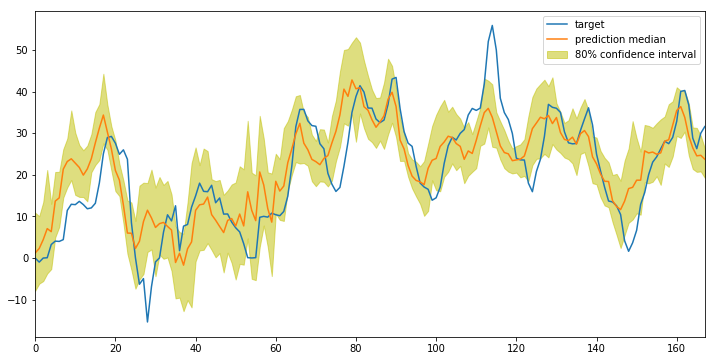

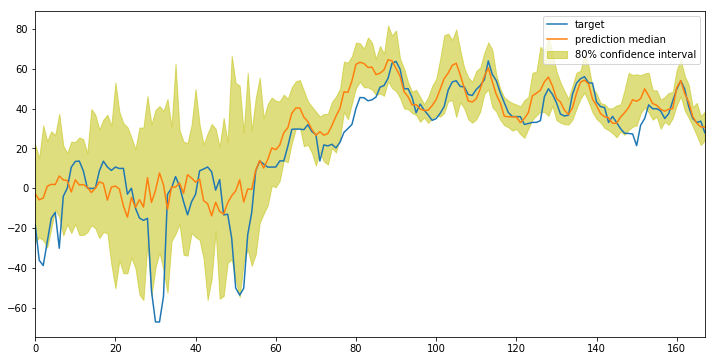

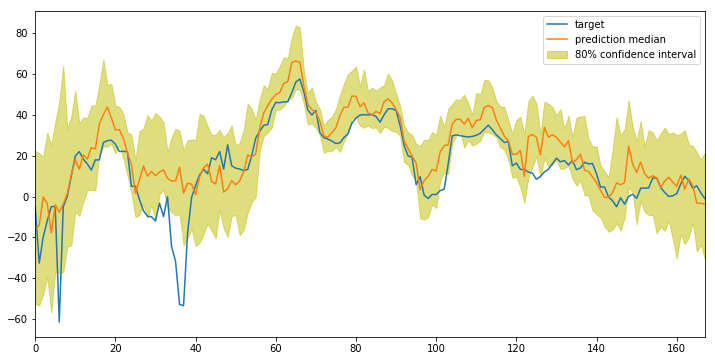

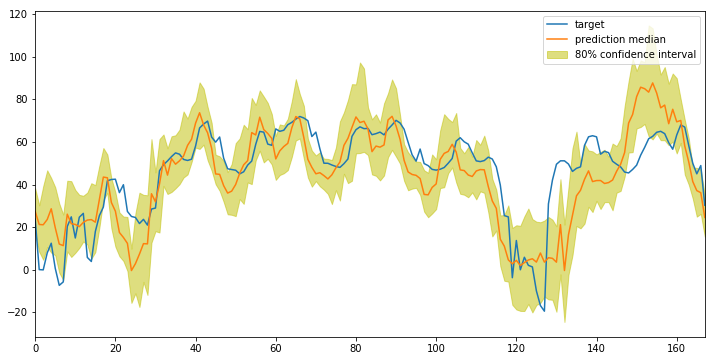

In [44]:
if testing == True:
    # display predictions
    target_ts=time_series_1
    display_quantiles(prediction_list, target_ts)

## Predicting the Future

Recall that we did not give our model any data about 2010, but let's see if it can predict the energy consumption given **no target**, only a known start date!

### EXERCISE: Format a request for a "future" prediction

Create a formatted input to send to the deployed `predictor` passing in my usual parameters for "configuration". The "instances" will, in this case, just be one instance, defined by the following:
* **start**: The start time will be time stamp that you specify. To predict the first 30 days of 2010, start on Jan. 1st, '2010-01-01'.
* **target**: The target will be an empty list because this year has no, complete associated time series; we specifically withheld that information from our model, for testing purposes.
```
{"start": start_time, "target": []} # empty target
```

In [45]:
# Starting my prediction at the beginning of 2019
year='2019'
start_date = year+'-01-01'
timestamp = '00:00:00'

# formatting start_date
start_time = start_date +' '+ timestamp

# Setting Dynamic feature
dynamic_feat_1 = []
dynamic_feat_2 = []
dynamic_feat_3 = []

# range of actual data to compare
start_idx=0 # hours since Jan 1st 2019
end_idx=start_idx+prediction_length

# create dynamic feature time series for the year
data=column_s2.loc[start_time:]
dynamic_feat_1.append(pd.Series(data=data))

data=column_s3.loc[start_time:]
dynamic_feat_2.append(pd.Series(data=data))

data=column_s4.loc[start_time:]
dynamic_feat_3.append(pd.Series(data=data))

# get target data
dynamic_feature_1 = dynamic_feat_1[0][start_idx:end_idx]
dynamic_feature_2 = dynamic_feat_2[0][start_idx:end_idx]
dynamic_feature_3 = dynamic_feat_3[0][start_idx:end_idx]

# formatting request_data
# this instance has an empty target!
if hyperparameters["num_dynamic_feat"]=="auto":
    request_data = {"instances": [{"start": start_time, "target": [], "dynamic_feat": [dynamic_feature_1.tolist(),dynamic_feature_2.tolist(),dynamic_feature_3.tolist()]}],
                    "configuration": {"num_samples": 50,
                                      "output_types": ["quantiles"],
                                      "quantiles": ['0.1', '0.5', '0.9']}
                    }
if hyperparameters["num_dynamic_feat"]=="ignore":
    request_data = {"instances": [{"start": start_time, "target": []}],
                    "configuration": {"num_samples": 50,
                                      "output_types": ["quantiles"],
                                      "quantiles": ['0.1', '0.5', '0.9']}
                    }

json_input = json.dumps(request_data).encode('utf-8')

print('Requesting prediction for '+start_time)

Requesting prediction for 2019-01-01 00:00:00


Then get and decode the prediction response, as usual.

In [46]:
# get prediction response
json_prediction = predictor.predict(json_input)

prediction_2019 = decode_prediction(json_prediction)

Upon completion of deployment, your predictor will have an handle to the endpoint you just provisioned, but if using this notebook at any later time, or with a previously deployed endpoint, you can simply obtain a handle to the the endpoint, by specifying the name of it.

In [ ]:
# get prediction response
'''
endpoint='the name you did to your Endpoint'
predictor=sagemaker.predictor.RealTimePredictor(endpoint)

json_prediction = predictor.predict(json_input)

prediction_2019 = decode_prediction(json_prediction)
'''

Finally, I'll compare the predictions to a known target sequence. This target will come from a time series for the 2019 data, which I'm creating below.

In [47]:
ts_2019 = []

data=column_s1.loc[year+'-01-01 00:00:00':]

# create time series for the year
ts_2019.append(pd.Series(data=data))

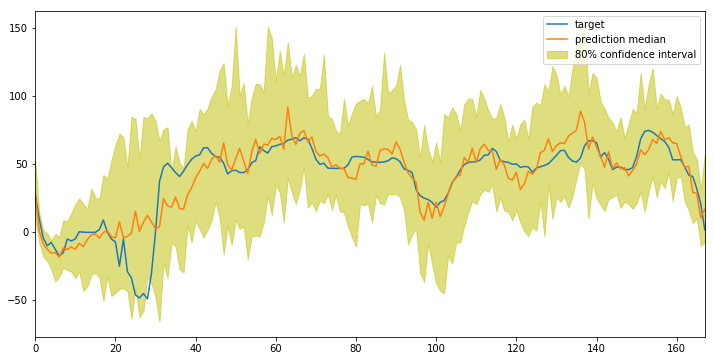

In [48]:
# get target data
target_2019_ts = [ts_2019[0][start_idx:end_idx]]

# display predictions
display_quantiles(prediction_2019, target_2019_ts)

In [49]:
# root mean squared error (RMSE)
from sklearn.metrics import mean_squared_error
from math import sqrt

def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

measure_rmse(target_2019_ts[0].tolist(),prediction_2019[0]['0.5'])

14.443980227477219

In [50]:
predictor.delete_endpoint()